### Storm fault footprint test ###

Testing creating a GIF of faults/population for a specific storm.

Ben Hutchins, June 13th 2025

In [1]:
# standard libraries
from pathlib import Path

# maths libraries
import numpy as np

# geodata libraries
import pandas as pd
import geopandas as gpd
import shapely
import rasterio

# plotting libraries (not required for the actual calculations)
import matplotlib.pyplot as plt

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
# Set up the shapefile path
DNO_shpfile_path = "/home/users/benhutch/energy-sotcr-2024-2025/shapes_and_masks/DNOs/DNO_License_Areas_20240503_latlon.shx"

In [3]:
DNO_shpfile_path

'/home/users/benhutch/energy-sotcr-2024-2025/shapes_and_masks/DNOs/DNO_License_Areas_20240503_latlon.shx'

In [4]:
shapefile_paths = {
    "DNO": Path("/home/users/benhutch/energy-sotcr-2024-2025/shapes_and_masks/DNOs/DNO_License_Areas_20240503_latlon.shp")
}

In [5]:
# Read in NESO's DNO shapefile with geopandas
dno_shapes = gpd.read_file(shapefile_paths["DNO"])

In [6]:
dno_shapes.head()

,geometry
0,"MULTIPOLYGON (((0.87474 51.51298, 0.87656 51.5..."
1,"POLYGON ((0.26688 52.81243, 0.26698 52.81218, ..."
2,"POLYGON ((-0.24419 51.48844, -0.24509 51.48926..."
3,"MULTIPOLYGON (((-4.25501 53.38796, -4.2556 53...."
4,"POLYGON ((-1.95899 53.21664, -1.95676 53.21383..."


Load in the fault data for the relevant regions

In [7]:
# Set up the paths
fault_paths = {
    "SSEN_Scotland": Path("/home/users/benhutch/energy-sotcr-2024-2025/faults/fault_data/SSEN/nafirs-climate-related-faults-shepd.xlsx"),
    "SSEN_South": Path("/home/users/benhutch/energy-sotcr-2024-2025/faults/fault_data/SSEN/nafirs-all-faults-sepd.xlsx"),
    "SPEN": Path("/home/users/benhutch/energy-sotcr-2024-2025/faults/fault_data/SPEN/all-lv-faults-spd-spm.csv"),
    "ENWL": Path("/home/users/benhutch/energy-sotcr-2024-2025/faults/fault_data/ENWL/unplanned-outages.csv"),
    "NPG_lv": Path("/home/users/benhutch/energy-sotcr-2024-2025/faults/fault_data/NPG/Northern_Powergrid_LV_Data_2025-04-30-05-00-38_MET Office.xlsb"),
    "NPG_hv": Path("/home/users/benhutch/energy-sotcr-2024-2025/faults/fault_data/NPG/Northern_Powergrid_HV_Data_2025-04-30-05-00-38_MET Office.xlsb"),
}

In [8]:
#-------------------------------
# SSEN North Scotland Faults
#-------------------------------

# Load in the SSEN_Scotland data as xlsx
ssen_scotland_faults = pd.read_excel(fault_paths["SSEN_Scotland"])

# Subset to "Reporting Year" == 2024 (April 2023 to March 2024)
ssen_scotland_faults_2024 = ssen_scotland_faults[ssen_scotland_faults["Reporting Year"] == 2024]

# Limit to Cause codes 1-25
ssen_scotland_faults_2024 = ssen_scotland_faults_2024[ssen_scotland_faults_2024["Cause Code"].isin(range(1, 26))]

In [9]:
# ------------------------------
# SPEN Faults - South Scotland and North Wales
# ------------------------------

# Load in the SPEN data as csv
spen_faults = pd.read_csv(fault_paths["SPEN"])

# Subset to "Reporting Year" == 2024 (April 2023 to March 2024)
spen_faults_2024 = spen_faults[spen_faults["Reporting Year"] == 2024]

# Split into South Scotland and North Wales
# SPM - England and North Wales
# SPD - South Scotland
spen_faults_N_Wales_2024 = spen_faults_2024[spen_faults_2024["Licence"] == "SPM"]
spen_faults_S_Scotland_2024 = spen_faults_2024[spen_faults_2024["Licence"] == "SPD"]

# ------------------------------
# NOTE: The SPEN faults data does not have a Cause Code, so we cannot filter by Cause Code like we did for SSEN.
# ------------------------------

In [10]:
# ------------------------------
# ENWL Faults - North West England
# ------------------------------

# Load in the ENWL data as csv
enwl_faults = pd.read_csv(fault_paths["ENWL"], low_memory=False)

# Convert 'Incident Date-time' to datetime format, forcing UTC
enwl_faults['Incident Date-time'] = pd.to_datetime(
    enwl_faults['Incident Date-time'], 
    format='%Y-%m-%dT%H:%M:%S%z', 
    errors='coerce', 
    utc=True
)

# Drop rows with invalid datetime values
enwl_faults = enwl_faults.dropna(subset=['Incident Date-time'])

# Subset to "Incident Date-time" in 2024
enwl_faults_2024 = enwl_faults[enwl_faults['Incident Date-time'].dt.year == 2024]

# Limit to "Direct Cause Category" == "Weather and Environment"
enwl_faults_2024 = enwl_faults_2024[enwl_faults_2024["Direct Cause Category"] == "Weather and Environment"]

In [11]:
# ------------------------------
# NPG Faults - Northern Powergrid low voltage and high voltage
# ------------------------------

# Load in the NPG low voltage data as xlsb
npg_lv_faults = pd.read_excel(fault_paths["NPG_lv"])

# if 45385.586111 = 03/04/2024  14:04:00
# and 45388.201389 =  06/04/2024  04:50:00
# Convert 'Incident Start' to datetime format
npg_lv_faults['Incident Start'] = pd.to_datetime(
    np.floor(npg_lv_faults['Incident Start']), 
    unit='D', 
    origin='1899-12-30', 
    utc=True
)

# load in the NPG high voltage data as xlsb
npg_hv_faults = pd.read_excel(fault_paths["NPG_hv"])

# Convert 'Incident Start' to datetime format
npg_hv_faults['Incident Start'] = pd.to_datetime(
    np.floor(npg_hv_faults['Incident Start']), 
    unit='D', 
    origin='1899-12-30', 
    utc=True
)

# limit lv to 2024
npg_lv_faults_2024 = npg_lv_faults[npg_lv_faults['Incident Start'].dt.year == 2024]
# limit hv to 2024
npg_hv_faults_2024 = npg_hv_faults[npg_hv_faults['Incident Start'].dt.year == 2024]

In [20]:
npg_hv_faults_2024['Customers']

0      1121
1       144
2       114
3      1163
4       667
       ... 
763     288
764    2596
765      35
766     226
767     253
Name: Customers, Length: 768, dtype: int64

In [30]:
# create a dictionary of column name to use
customer_column_names = {
    "SSEN": "hv cust affected",
    "SPEN": "Customers Interrupted",
    "ENWL": "Customer Affected",
    "NPG": "Customers",
}

time_column_names = {
    "SSEN": "Incident Time",
    "SPEN": "Date/Time of Incidents",
    "ENWL": "Incident Date-time",
    "NPG": "Incident Start",
}

# Set up the dictionary for population data
dno_data = {
    "UKPN_East_England": {
        "Name": "_A", "Population %": 13.11, "Cosine Weighted Population %": 13.31
    },
    "NGED_East_Midlands": {
        "Name": "_B", "Population %": 10.04, "Cosine Weighted Population %": 10.01
    },
    "UKPN_London": {
        "Name": "_C", "Population %": 7.36, "Cosine Weighted Population %": 7.54
    },
    "SPEN_North_Wales_Merseyside_and_Cheshire": {
        "Name": "_D", "Population %": 4.41, "Cosine Weighted Population %": 4.35
    },
    "NGED_West_Midlands": {
        "Name": "_E", "Population %": 9.87, "Cosine Weighted Population %": 9.90
    },
    "NPG_North_East_England": {
        "Name": "_F", "Population %": 4.14, "Cosine Weighted Population %": 3.93
    },
    "ENWL_North_West_England": {
        "Name": "_G", "Population %": 7.43, "Cosine Weighted Population %": 7.24
    },
    "SSEN_North_Scotland": {
        "Name": "_P", "Population %": 1.85, "Cosine Weighted Population %": 1.65
    },
    "UKPN_South_East_England": {
        "Name": "_J", "Population %": 8.41, "Cosine Weighted Population %": 8.67
    },
    "NGED_South_Wales": {
        "Name": "_K", "Population %": 4.92, "Cosine Weighted Population %": 5.03
    },
    "NGED_South_West_England": {
        "Name": "_L", "Population %": 4.67, "Cosine Weighted Population %": 4.85
    },
    "NPG_Yorkshire": {
        "Name": "_M", "Population %": 7.08, "Cosine Weighted Population %": 6.90
    },
    "SPEN_South_and_Central_Scotland": {
        "Name": "_N", "Population %": 5.41, "Cosine Weighted Population %": 5.00
    },
    "SSEN_Southern_England": {
        "Name": "_H", "Population %": 11.29, "Cosine Weighted Population %": 11.62
    },
}

# Set up the UK population in 2019
uk_population_2019 = 66840000 # in millions

# Calculate the population for each DNO
for dno, data in dno_data.items():
    population_percentage = data["Cosine Weighted Population %"]
    data["Population"] = (population_percentage / 100) * uk_population_2019

In [51]:
dno_data["SSEN_North_Scotland]

{'Name': '_P',
 'Population %': 1.85,
 'Cosine Weighted Population %': 1.65,
 'Population': 1102860.0}

In [31]:
npg_hv_faults_2024.head()

,Grouping,Business,Repair Zone,Incident Ref,Incident Start,Incident End,INC_CATEGORY_DESC,Damage / Non Damage,Voltage,Customers,...,EQUIPMENT_DETAILS4,EQUIPMENT_DETAILS4_DESC,EQUIPMENT_DETAILS5,EQUIPMENT_DETAILS5_DESC,COMPONENT,COMPONENT_DESC,Primary,SECONDARY_CAUSE,SECONDARY_CAUSE_DESC,Weather check
0,PESC,Yorkshire,Yorkshire Moors & Wolds YK,INCD-508919-A,2024-04-01 00:00:00+00:00,45383.786713,HV Restoration,Non Damage,11.0,1121,...,NaN,NaN,NaN,NaN,NaN,NaN,MARTONGATE,X,NONE,YES
1,PESC,Northeast,Tyne and Wear,INCD-509543-A,2024-04-04 00:00:00+00:00,45386.468750,HV Restoration,Non Damage,11.0,144,...,1,0.71 to 0.9,NaN,NaN,40.0,"Conductor, phase - bare",BENTON SQUARE,X,NONE,YES
2,PESC,Northeast,Yorkshire Dales NE,INCD-510108-A,2024-04-06 00:00:00+00:00,45393.572222,O/H HV Mains Repair,Damage,11.0,114,...,1,0.71 to 0.9,NaN,NaN,40.0,"Conductor, phase - bare",RIPON,X,NONE,YES
3,PESC,Yorkshire,West Yorkshire,INCD-510112-A,2024-04-06 00:00:00+00:00,45388.972222,HV Restoration,Non Damage,11.0,1163,...,NaN,NaN,NaN,NaN,NaN,NaN,HAWORTH,X,NONE,YES
4,PESC,Northeast,Yorkshire Dales NE,INCD-510122-A,2024-04-06 00:00:00+00:00,45388.845139,O/H HV Mains Repair,Damage,11.0,667,...,X,NaN,NaN,NaN,40.0,"Conductor, phase - bare",THIRSK,X,NONE,YES


In [48]:
# Subset the SSEN Scotland faults to the date column and the customer column name
ssen_scotland_faults_2024_subset = ssen_scotland_faults_2024.loc[:, [time_column_names["SSEN"], customer_column_names["SSEN"]]]

# Format the time column to datetime
ssen_scotland_faults_2024_subset.loc[:, time_column_names["SSEN"]] = pd.to_datetime(
    ssen_scotland_faults_2024_subset[time_column_names["SSEN"]], 
    format='%Y-%m-%d %H:%M:%S', 
    errors='coerce', 
    utc=True
)

# Format as days
ssen_scotland_faults_2024_subset["Incident Day"] = ssen_scotland_faults_2024_subset[time_column_names["SSEN"]].dt.floor('D')

# Format incident day to string for grouping
ssen_scotland_faults_2024_subset["Incident Day"] = ssen_scotland_faults_2024_subset["Incident Day"].astype(str)

# Ensure the customer column is numeric for summing
ssen_scotland_faults_2024_subset[customer_column_names["SSEN"]] = pd.to_numeric(
    ssen_scotland_faults_2024_subset[customer_column_names["SSEN"]], 
    errors='coerce'
)

# Sum the customers affected by day
ssen_scotland_faults_2024_daily = ssen_scotland_faults_2024_subset.groupby("Incident Day")[customer_column_names["SSEN"]].sum().reset_index()

# format as hv customers affected per 1,000,000 population
ssen_scotland_faults_2024_daily["HV Customers Affected per 1M Population"] = (
    ssen_scotland_faults_2024_daily[customer_column_names["SSEN"]] / dno_data["SSEN_North_Scotland"]["Population"]
) * 1_000_000

/tmp/ipykernel_3464850/3224386735.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<DatetimeArray>
['2024-04-02 18:04:00+00:00', '2024-04-03 14:52:00+00:00',
 '2024-04-04 04:30:00+00:00', '2024-04-04 07:01:00+00:00',
 '2024-04-04 14:31:00+00:00', '2024-04-05 06:45:00+00:00',
 '2024-04-06 09:01:00+00:00', '2024-04-06 09:01:00+00:00',
 '2024-04-06 10:43:00+00:00', '2024-04-06 12:48:00+00:00',
 ...
 '2024-12-31 05:40:00+00:00', '2024-12-31 06:17:00+00:00',
 '2024-12-31 06:45:00+00:00', '2024-12-31 07:50:00+00:00',
 '2024-12-31 07:50:00+00:00', '2024-12-31 08:10:00+00:00',
 '2024-12-31 08:58:00+00:00', '2024-12-31 11:03:00+00:00',
 '2024-12-31 12:31:00+00:00', '2024-12-31 15:12:00+00:00']
Length: 539, dtype: datetime64[ns, UTC]' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  ssen_scotland_faults_2024_subset.loc[:, time_column_names["SSEN"]] = pd.to_datetime(


In [49]:
ssen_scotland_faults_2024_daily.head()

,Incident Day,hv cust affected,HV Customers Affected per 1M Population
0,2024-04-02 00:00:00+00:00,22,19.948135
1,2024-04-03 00:00:00+00:00,27,24.481802
2,2024-04-04 00:00:00+00:00,509,461.527302
3,2024-04-05 00:00:00+00:00,670,607.511380
4,2024-04-06 00:00:00+00:00,1948,1766.316668


In [73]:
# ----------------------------
# Same for the SPEN data
# ----------------------------

# Subset the SPEN South Scotland faults to the date column and the customer column name
spen_south_scotland_faults_2024_subset = spen_faults_S_Scotland_2024.loc[:, [time_column_names["SPEN"], customer_column_names["SPEN"]]]

# Do the same for north wales
spen_north_wales_faults_2024_subset = spen_faults_N_Wales_2024.loc[:, [time_column_names["SPEN"], customer_column_names["SPEN"]]]

# Take the time column and format it to datetime
spen_south_scotland_faults_2024_subset.loc[:, time_column_names["SPEN"]] = pd.to_datetime(
    spen_south_scotland_faults_2024_subset[time_column_names["SPEN"]], 
    errors='coerce', 
    utc=True
)

# same with n wales
spen_north_wales_faults_2024_subset.loc[:, time_column_names["SPEN"]] = pd.to_datetime(
    spen_north_wales_faults_2024_subset[time_column_names["SPEN"]],
    errors='coerce',
    utc=True
)

# print the type of the time column
print(type(spen_south_scotland_faults_2024_subset[time_column_names["SPEN"]].iloc[0]))
# Check the first few rows of the time column
print(spen_south_scotland_faults_2024_subset[time_column_names["SPEN"]].head())

# format as datetime
spen_south_scotland_faults_2024_subset[time_column_names["SPEN"]] = pd.to_datetime(
    spen_south_scotland_faults_2024_subset[time_column_names["SPEN"]],
    format='%Y-%m-%d %H:%M:%S',
    errors='coerce',
    utc=True
)

# convert again
spen_north_wales_faults_2024_subset[time_column_names["SPEN"]] = pd.to_datetime(
    spen_north_wales_faults_2024_subset[time_column_names["SPEN"]],
    format='%Y-%m-%d %H:%M:%S',
    errors='coerce',
    utc=True
)

# print the type of the time column again
print(type(spen_south_scotland_faults_2024_subset[time_column_names["SPEN"]].iloc[0]))
# print the type of the n wales one
print(type(spen_north_wales_faults_2024_subset[time_column_names["SPEN"]].iloc[0]))

# # Sum these by day
spen_south_scotland_faults_2024_subset["Incident Day"] = spen_south_scotland_faults_2024_subset[time_column_names["SPEN"]].dt.floor('D')
spen_north_wales_faults_2024_subset["Incident Day"] = spen_north_wales_faults_2024_subset[time_column_names["SPEN"]].dt.floor('D')

# Format incident day to string for grouping
spen_south_scotland_faults_2024_subset["Incident Day"] = spen_south_scotland_faults_2024_subset["Incident Day"].astype(str)
spen_north_wales_faults_2024_subset["Incident Day"] = spen_north_wales_faults_2024_subset["Incident Day"].astype(str)

# Ensure the customer column is numeric for summing
spen_south_scotland_faults_2024_subset[customer_column_names["SPEN"]] = pd.to_numeric(
    spen_south_scotland_faults_2024_subset[customer_column_names["SPEN"]], 
    errors='coerce'
)
spen_north_wales_faults_2024_subset[customer_column_names["SPEN"]] = pd.to_numeric(
    spen_north_wales_faults_2024_subset[customer_column_names["SPEN"]], 
    errors='coerce'
)

# Sum the customers affected by day
spen_south_scotland_faults_2024_daily = spen_south_scotland_faults_2024_subset.groupby("Incident Day")[customer_column_names["SPEN"]].sum().reset_index()
# format as hv customers affected per 1,000,000 population
spen_south_scotland_faults_2024_daily["HV Customers Affected per 1M Population"] = (
    spen_south_scotland_faults_2024_daily[customer_column_names["SPEN"]] / dno_data["SPEN_South_and_Central_Scotland"]["Population"]
) * 1_000_000

spen_north_wales_faults_2024_daily = spen_north_wales_faults_2024_subset.groupby("Incident Day")[customer_column_names["SPEN"]].sum().reset_index()
# format as hv customers affected per 1,000,000 population
spen_north_wales_faults_2024_daily["HV Customers Affected per 1M Population"] = (
    spen_north_wales_faults_2024_daily[customer_column_names["SPEN"]] / dno_data["SPEN_North_Wales_Merseyside_and_Cheshire"]["Population"]
) * 1_000_000

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
39240    2024-08-19 13:30:00+00:00
39241    2024-08-19 18:15:00+00:00
39244    2024-08-19 19:20:00+00:00
39246    2024-08-19 20:21:00+00:00
39247    2024-08-20 06:04:59+00:00
Name: Date/Time of Incidents, dtype: object
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [74]:
spen_north_wales_faults_2024_daily.head()

,Incident Day,Customers Interrupted,HV Customers Affected per 1M Population
0,2024-04-01 00:00:00+00:00,154.0,52.965737
1,2024-04-02 00:00:00+00:00,148.0,50.902137
2,2024-04-03 00:00:00+00:00,93.0,31.985802
3,2024-04-04 00:00:00+00:00,235.0,80.824339
4,2024-04-05 00:00:00+00:00,117.0,40.240203


In [75]:
spen_south_scotland_faults_2024_daily.head()

,Incident Day,Customers Interrupted,HV Customers Affected per 1M Population
0,2024-04-01 00:00:00+00:00,156.0,46.678636
1,2024-04-02 00:00:00+00:00,581.0,173.847995
2,2024-04-03 00:00:00+00:00,386.0,115.499701
3,2024-04-04 00:00:00+00:00,627.0,187.612208
4,2024-04-05 00:00:00+00:00,957.0,286.355476


In [84]:
# Do the same for enwl
# Subset the ENWL faults to the date column and the customer column name
enwl_faults_2024_subset = enwl_faults_2024.loc[:, [time_column_names["ENWL"], customer_column_names["ENWL"]]]

# Take the time column and format it to datetime
enwl_faults_2024_subset.loc[:, time_column_names["ENWL"]] = pd.to_datetime(
    enwl_faults_2024_subset[time_column_names["ENWL"]],
    errors='coerce',
    utc=True
)

# print the type of the time column
print(type(enwl_faults_2024_subset[time_column_names["ENWL"]].iloc[0]))

# add a new column for the incident day
enwl_faults_2024_subset["Incident Day"] = enwl_faults_2024_subset[time_column_names["ENWL"]].dt.floor('D')

# Format incident day to string for grouping
enwl_faults_2024_subset["Incident Day"] = enwl_faults_2024_subset["Incident Day"].astype(str)

# Ensure the customer column is numeric for summing
enwl_faults_2024_subset[customer_column_names["ENWL"]] = pd.to_numeric(
    enwl_faults_2024_subset[customer_column_names["ENWL"]],
    errors='coerce'
)

# Sum the customers affected by day
enwl_faults_2024_daily = enwl_faults_2024_subset.groupby("Incident Day")[customer_column_names["ENWL"]].sum().reset_index()

# format as hv customers affected per 1,000,000 population
enwl_faults_2024_daily["HV Customers Affected per 1M Population"] = (
    enwl_faults_2024_daily[customer_column_names["ENWL"]] / dno_data["ENWL_North_West_England"]["Population"]
) * 1_000_000

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [85]:
enwl_faults_2024_daily.head()

,Incident Day,Customer Affected,HV Customers Affected per 1M Population
0,2024-01-01 00:00:00+00:00,2.0,0.413290
1,2024-01-02 00:00:00+00:00,6.0,1.239870
2,2024-01-03 00:00:00+00:00,187.0,38.642623
3,2024-01-04 00:00:00+00:00,84.0,17.358184
4,2024-01-05 00:00:00+00:00,167.0,34.509722


In [91]:
# Do the same for NPG low voltage faults and high voltage faults
# Subset the NPG low voltage faults to the date column and the customer column name
npg_lv_faults_2024_subset = npg_lv_faults_2024.loc[:, [time_column_names["NPG"], customer_column_names["NPG"]]]
# same for hv faults
npg_hv_faults_2024_subset = npg_hv_faults_2024.loc[:, [time_column_names["NPG"], customer_column_names["NPG"]]]

# Take the time column and format it to datetime
npg_lv_faults_2024_subset.loc[:, time_column_names["NPG"]] = pd.to_datetime(
    npg_lv_faults_2024_subset[time_column_names["NPG"]],
    errors='coerce',
    utc=True
)

# same for hv faults
npg_hv_faults_2024_subset.loc[:, time_column_names["NPG"]] = pd.to_datetime(
    npg_hv_faults_2024_subset[time_column_names["NPG"]],
    errors='coerce',
    utc=True
)

# print the type of the time column
print(type(npg_lv_faults_2024_subset[time_column_names["NPG"]].iloc[0]))

# add a new column for the incident day
npg_lv_faults_2024_subset["Incident Day"] = npg_lv_faults_2024_subset[time_column_names["NPG"]].dt.floor('D')

# same for hv faults
npg_hv_faults_2024_subset["Incident Day"] = npg_hv_faults_2024_subset[time_column_names["NPG"]].dt.floor('D')

# Format incident day to string for grouping
npg_lv_faults_2024_subset["Incident Day"] = npg_lv_faults_2024_subset["Incident Day"].astype(str)

npg_hv_faults_2024_subset["Incident Day"] = npg_hv_faults_2024_subset["Incident Day"].astype(str)

# Ensure the customer column is numeric for summing
npg_lv_faults_2024_subset[customer_column_names["NPG"]] = pd.to_numeric(
    npg_lv_faults_2024_subset[customer_column_names["NPG"]],
    errors='coerce'
)

# same for hv faults
npg_hv_faults_2024_subset[customer_column_names["NPG"]] = pd.to_numeric(
    npg_hv_faults_2024_subset[customer_column_names["NPG"]],
    errors='coerce'
)

# Sum the customers affected by day
npg_lv_faults_2024_daily = npg_lv_faults_2024_subset.groupby("Incident Day")[customer_column_names["NPG"]].sum().reset_index()

# format as hv customers affected per 1,000,000 population
npg_lv_faults_2024_daily["HV Customers Affected per 1M Population"] = (
    npg_lv_faults_2024_daily[customer_column_names["NPG"]] / dno_data["NPG_North_East_England"]["Population"]
) * 1_000_000

npg_hv_faults_2024_daily = npg_hv_faults_2024_subset.groupby("Incident Day")[customer_column_names["NPG"]].sum().reset_index()
# format as hv customers affected per 1,000,000 population
npg_hv_faults_2024_daily["HV Customers Affected per 1M Population"] = (
    npg_hv_faults_2024_daily[customer_column_names["NPG"]] / dno_data["NPG_North_East_England"]["Population"]
) * 1_000_000

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [95]:
spen_south_scotland_faults_2024_daily.tail()

,Incident Day,Customers Interrupted,HV Customers Affected per 1M Population
360,2025-03-27 00:00:00+00:00,467.0,139.736685
361,2025-03-28 00:00:00+00:00,300.0,89.766607
362,2025-03-29 00:00:00+00:00,38.0,11.370437
363,2025-03-30 00:00:00+00:00,290.0,86.774387
364,2025-03-31 00:00:00+00:00,468.0,140.035907


In [97]:
ssen_scotland_faults_2024_daily.tail()

,Incident Day,hv cust affected,HV Customers Affected per 1M Population
134,2024-12-26 00:00:00+00:00,14,12.694268
135,2024-12-27 00:00:00+00:00,2,1.813467
136,2024-12-29 00:00:00+00:00,953,864.116932
137,2024-12-30 00:00:00+00:00,855,775.257059
138,2024-12-31 00:00:00+00:00,5956,5400.504144


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

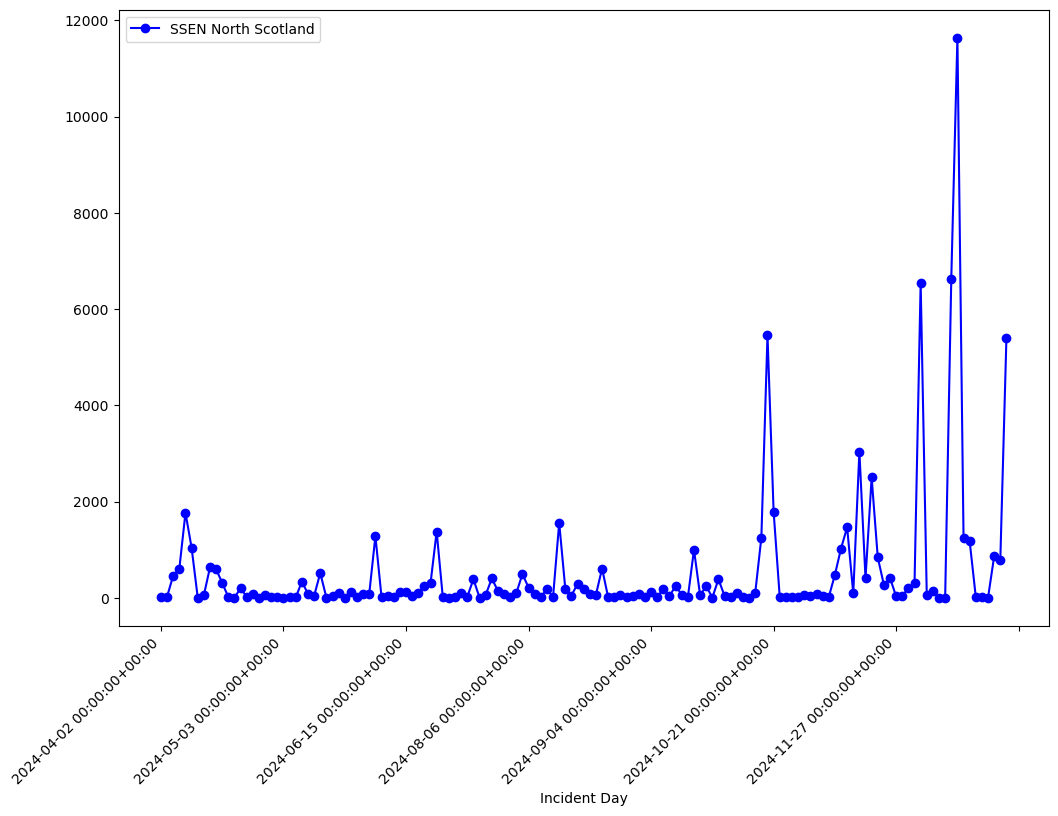

In [101]:
# Set up figure
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the SSEN North Scotland data
ssen_scotland_faults_2024_daily.plot(
    x="Incident Day", 
    y="HV Customers Affected per 1M Population", 
    ax=ax, 
    label="SSEN North Scotland", 
    color="blue", 
    marker='o'
)

# format the dates on the x-axis more nicely
ax.xaxis.set_major_locator(plt.MaxNLocator(10))  # Limit to 10 major ticks
# rotate the x-axis labels for better readability
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
